In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

Заказчику важны:

    качество предсказания;
    скорость предсказания;
    время обучения.



## Подготовка данных

In [ ]:
pip install --upgrade category_encoders

In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer

import category_encoders as ce

In [ ]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/autos.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
data.head(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [ ]:
data.columns = data.columns.str.lower()

In [ ]:
data.duplicated().sum()

4

In [ ]:
data = data.drop_duplicates()

In [ ]:
data.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
repaired             71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

In [ ]:
data['fueltype'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [ ]:
data.loc[(data['fueltype'] == 'gasoline') | (data['fueltype'] == 'petrol'), 'fueltype'] = 'benzine'

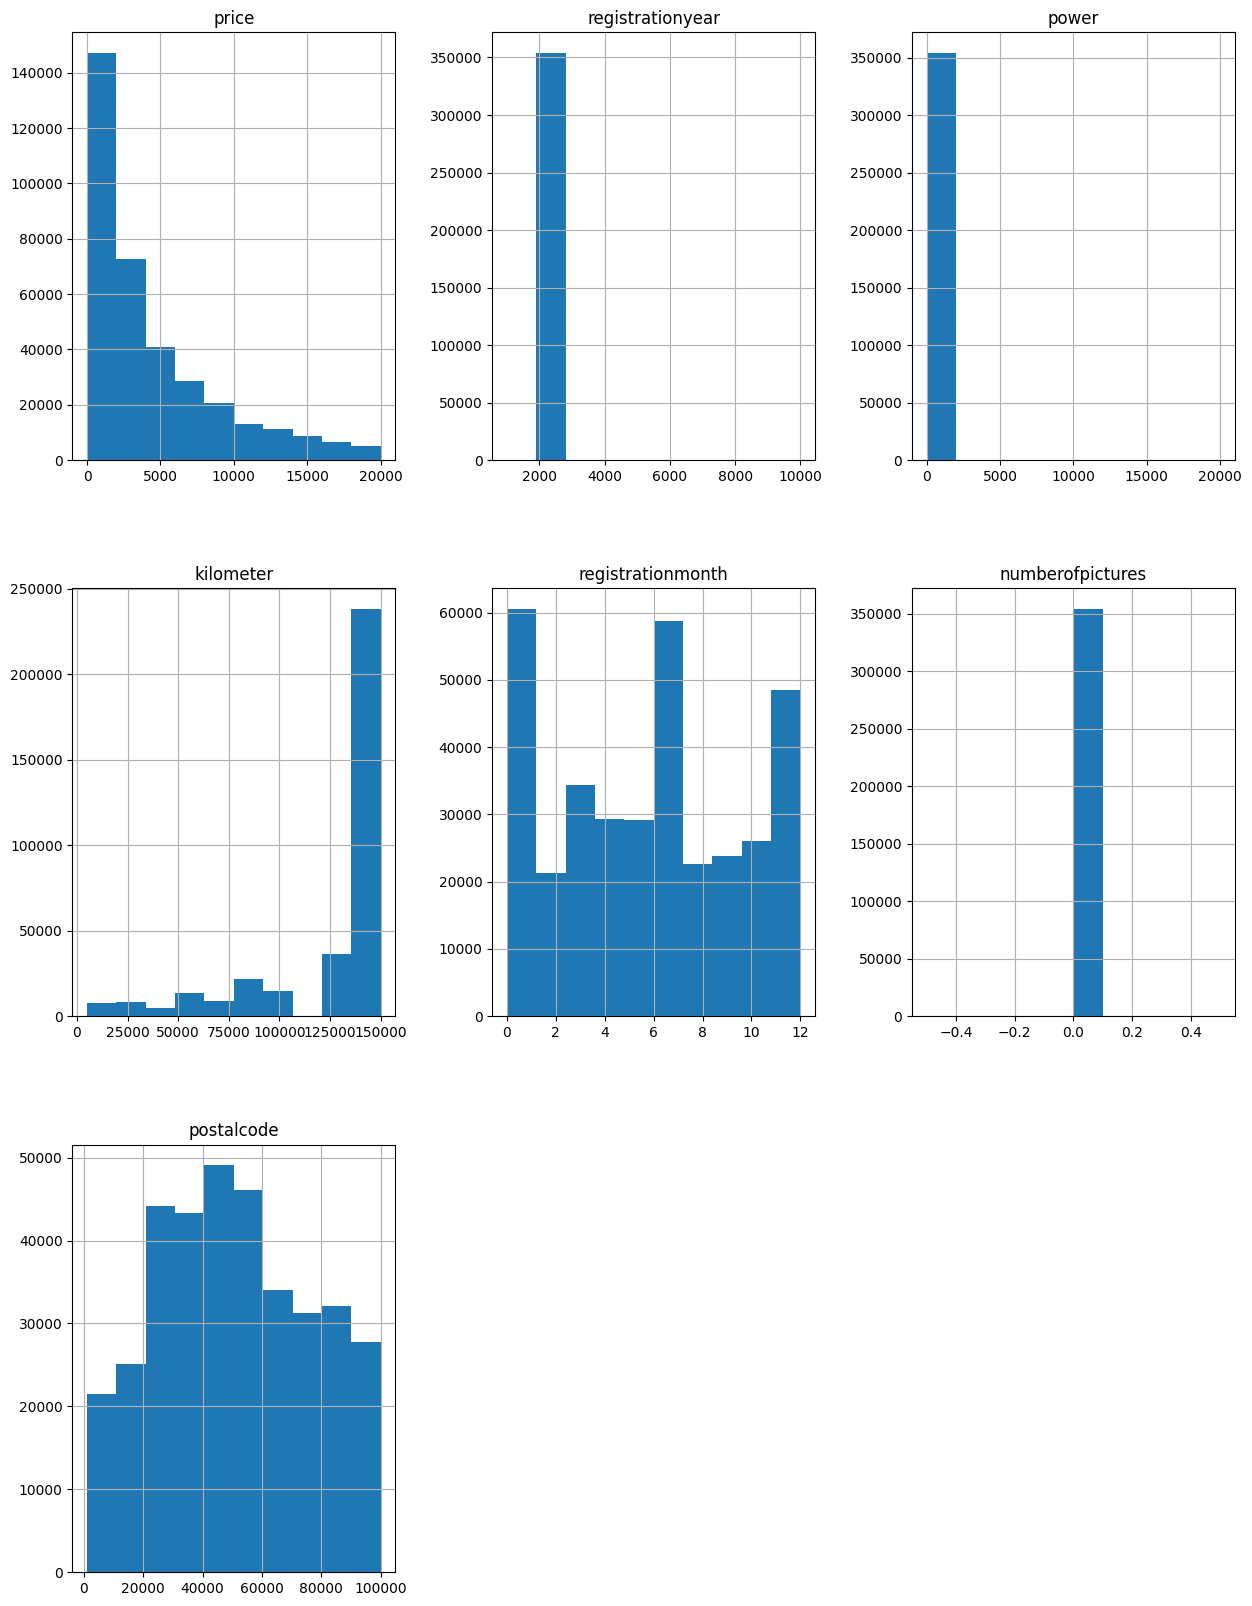

In [ ]:
data.hist(figsize = (15, 20));

Имеются аномальные значения цены.

Околонулевое значение столбца фотографий не может быть естественным, так как при продаже авто желательно иметь его фото, в большинстве случаев объявления без фотографий не рассматриваются и кажутся подозрительными, возможно, имеются ошибка в работе сервиса и обработке картинок, так же можно сделать поле с фото обязательным для заполнения при подаче объявления

In [ ]:
data[data['price'] == 0]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,benzine,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,benzine,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,benzine,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,benzine,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,benzine,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,benzine,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,benzine,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


In [ ]:
data = data[data['price'] != 0]

Обычно, минимальные л.с 100-130 для малых машин гольф-класса, все что меньше, может быть некорректным значением, удаляем.

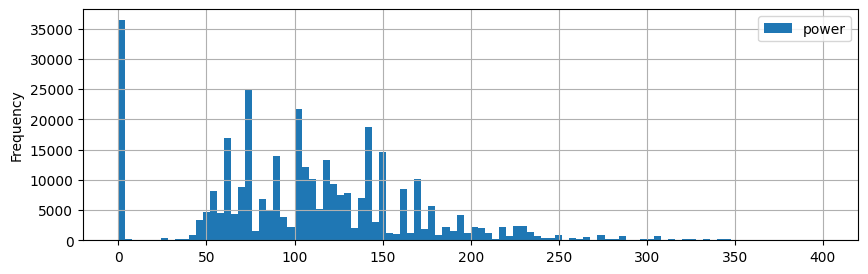

In [ ]:
data.plot(y = 'power', kind = 'hist', bins = 100, grid = True, figsize = (10 , 3) , range = (0 ,400));

In [ ]:
data = data[data['power'] >= 100]

In [ ]:
data['registrationyear'].unique()

array([2011, 2004, 1995, 2014, 1998, 2005, 2007, 2009, 2002, 1990, 2017,
       2006, 2012, 2008, 1994, 2000, 1992, 1997, 1984, 2003, 1999, 1991,
       1996, 2001, 2010, 2015, 2016, 1989, 2013, 1983, 2018, 1981, 1969,
       1993, 1985, 1988, 1980, 1986, 1965, 1974, 1987, 1982, 1978, 1976,
       1972, 1968, 1966, 1961, 1959, 1500, 1977, 1979, 1973, 1967, 1975,
       1800, 2019, 1971, 1958, 2900, 1945, 1962, 1400, 1970, 5000, 4000,
       1956, 1950, 1951, 1963, 6500, 1955, 1000, 1964, 1960, 1952, 6000,
       1957, 1910, 1948, 1954, 1937, 1947, 3000, 1600])

In [ ]:
data['datecrawled'].max()

'2016-04-07 14:36:58'

In [ ]:
data = data.loc[data['registrationyear'] >= 1900]
data = data.loc[data['registrationyear'] <= 2017]

Дата регистрации также имела аномалии, учитывая что машины от 1900 могут быть в самом деле на ходу, ограничились времнем от 1900 по нынешний год

In [ ]:
data = data.drop(columns = ['lastseen', 'datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode'])

In [ ]:
data = data.fillna('unknown')

In [ ]:
data.isna().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
repaired            0
dtype: int64

In [ ]:
data.reset_index(drop = True)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,18300,coupe,2011,manual,190,unknown,125000,benzine,audi,yes
1,9800,suv,2004,auto,163,grand,125000,benzine,jeep,unknown
2,650,sedan,1995,manual,102,3er,150000,benzine,bmw,yes
3,2200,convertible,2004,manual,109,2_reihe,150000,benzine,peugeot,no
4,14500,bus,2014,manual,125,c_max,30000,benzine,ford,unknown
...,...,...,...,...,...,...,...,...,...,...
194447,5250,unknown,2016,auto,150,159,150000,unknown,alfa_romeo,no
194448,3200,sedan,2004,manual,225,leon,150000,benzine,seat,yes
194449,1199,convertible,2000,auto,101,fortwo,125000,benzine,smart,no
194450,9200,bus,1996,manual,102,transporter,150000,benzine,volkswagen,no


Были удалены некорректные значения мощности, года регистрации и цены. Пропуски в категориальных столбцах были заменены на "неизвестно". Оставили только нужные для обучения данные

## Обучение моделей

In [ ]:
data_train, data_test = train_test_split(data, test_size = 0.4, random_state = 88)
data_test, data_valid = train_test_split(data_test, test_size = 0.5, random_state = 88)

In [ ]:
features_train = data_train.drop(['price'], axis = 1)
target_train = data_train['price']
features_test = data_test.drop(['price'], axis = 1)
target_test = data_test['price']
features_valid = data_valid.drop(['price'], axis = 1)
target_valid = data_valid['price']

In [ ]:
print(data.shape)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(194452, 10)
(116671, 9)
(116671,)
(38890, 9)
(38890,)
(38891, 9)
(38891,)


In [ ]:
numeric = ['registrationyear', 'power', 'kilometer']

In [ ]:
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [ ]:
var_categorical = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']
ce_ord = ce.OrdinalEncoder(cols = var_categorical)
features_train_oe = features_train.copy()
features_valid_oe = features_valid.copy()
features_test_oe = features_test.copy()
features_train_oe = ce_ord.fit_transform(features_train, target_train)
features_valid_oe = ce_ord.transform(features_valid, target_valid)
features_test_oe = ce_ord.transform(features_test, target_test)

In [ ]:
features_train_oe['brand'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])

### Линейная регрессия

In [64]:
%%time
line_model = LinearRegression()
line_model.fit(features_train_oe, target_train)
predicted = line_model.predict(features_valid_oe)
mse = mean_squared_error(target_valid, predicted)

print('RMSE - ', mse ** 0.5)

RMSE -  3602.952433853923
CPU times: user 56.6 ms, sys: 9.06 ms, total: 65.6 ms
Wall time: 53.1 ms


### CatBoostRegressor

In [ ]:
%%time

cat_model = CatBoostRegressor(random_seed = 88, cat_features = var_categorical, verbose = False)

grid = {'learning_rate': [0.01, 0.1, 0.5, 1, 2],
        'iterations': [20, 60],
        'depth': [6, 8, 10],
        }

result = cat_model.randomized_search(grid, X=features_train, y=target_train, n_iter = 100, refit = True, cv = 5, verbose = False, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 6638.103095
bestIteration = 19


bestTest = 2640.831204
bestIteration = 19


bestTest = 2095.609327
bestIteration = 19


bestTest = 2074.493087
bestIteration = 19



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 7361.451111
bestIteration = 19


bestTest = 4909.169598
bestIteration = 59


bestTest = 2147.636886
bestIteration = 59


bestTest = 1984.241028
bestIteration = 59


bestTest = 1987.22089
bestIteration = 59



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 7036.295878
bestIteration = 59


bestTest = 6619.766771
bestIteration = 19


bestTest = 2552.056548
bestIteration = 19


bestTest = 2042.981393
bestIteration = 19


bestTest = 2011.831271
bestIteration = 19



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 7169.909005
bestIteration = 19


bestTest = 4879.005582
bestIteration = 59


bestTest = 2071.651792
bestIteration = 59


bestTest = 1937.632283
bestIteration = 59


bestTest = 1941.291362
bestIteration = 59



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 6625.315363
bestIteration = 59


bestTest = 6612.335855
bestIteration = 19


bestTest = 2490.323829
bestIteration = 19


bestTest = 1998.734223
bestIteration = 19


bestTest = 2020.298062
bestIteration = 19



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 6971.940784
bestIteration = 19


bestTest = 4859.708115
bestIteration = 59


bestTest = 2019.01071
bestIteration = 59


bestTest = 1903.790331
bestIteration = 59


bestTest = 1963.044197
bestIteration = 59



learning rate is greater than 1. You probably need to decrease learning rate.



bestTest = 6051.0913
bestIteration = 59

Training on fold [0/5]

bestTest = 1886.809067
bestIteration = 58

Training on fold [1/5]

bestTest = 1905.588634
bestIteration = 59

Training on fold [2/5]

bestTest = 1946.339704
bestIteration = 59

Training on fold [3/5]

bestTest = 1939.209215
bestIteration = 59

Training on fold [4/5]

bestTest = 1910.538047
bestIteration = 59

CPU times: user 2min 32s, sys: 7.42 s, total: 2min 40s
Wall time: 1min 41s


### LightGBM

In [ ]:
%%time

light_model = LGBMRegressor(random_state = 88)
light_params = {'n_estimators': [10, 50, 100],
               'max_depth': [15, 30],
               'num_leaves': [10, 20, 31],
               'learning_rate': [0.1]}
light_cv = GridSearchCV(light_model,
                             light_params,
                             cv = 5,
                             scoring = 'neg_mean_squared_error',
                             verbose = False,
                             error_score = 'raise')

light_cv.fit(features_train_oe, target_train)

print(light_cv.best_params_)
print('RMSE - ', (-light_cv.best_score_) ** 0.5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 93336, number of used features: 9
[LightGBM] [Info] Start training from score 6088.693998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 93337, number of used features: 9
[LightGBM] [Info] Start training from score 6096.187675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 93337, number of used features: 9
[LightGBM] [Info] 

LightGBM работет быстрее CatBoost со средней метрикой.

## Анализ моделей

In [ ]:
%%time
line_model = LinearRegression()
line_model.fit(features_train_oe, target_train)

CPU times: user 54.3 ms, sys: 6.93 ms, total: 61.2 ms
Wall time: 79.4 ms


LinearRegression()

In [ ]:
%%time
predicted = line_model.predict(features_valid_oe)
mse = mean_squared_error(target_valid, predicted)

CPU times: user 6.62 ms, sys: 1.02 ms, total: 7.63 ms
Wall time: 6.57 ms


In [ ]:
print('RMSE - ', mse ** 0.5)

RMSE -  3602.952433853923


In [ ]:
%%time
cat_model = CatBoostRegressor(random_seed = 88, cat_features = var_categorical, learning_rate= 0.5, iterations= 60, depth= 10, verbose=False)
cat_model.fit(features_train, target_train)

CPU times: user 8.85 s, sys: 169 ms, total: 9.02 s
Wall time: 4.89 s


In [ ]:
%%time
target_predict = cat_model.predict(features_valid)
mse = mean_squared_error(target_valid, target_predict)

CPU times: user 99.7 ms, sys: 2.96 ms, total: 103 ms
Wall time: 82.3 ms


In [ ]:
print('RMSE - ', mse** 0.5)

RMSE -  1876.0476964963168


In [ ]:
%%time
lgb_model_fin = LGBMRegressor(random_state = 88, n_estimators = 100, max_depth = 30, num_leaves = 31, learning_rate = 0.1)
lgb_model_fin.fit(features_train_oe, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 116671, number of used features: 9
[LightGBM] [Info] Start training from score 6097.523429
CPU times: user 1.4 s, sys: 11.9 ms, total: 1.41 s
Wall time: 1.52 s


LGBMRegressor(max_depth=30, random_state=88)

In [ ]:
%%time
target_predict = lgb_model_fin.predict(features_valid_oe)
mse = mean_squared_error(target_valid, target_predict)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 309 ms, sys: 1.96 ms, total: 311 ms
Wall time: 306 ms


In [ ]:
print('RMSE - ', mse** 0.5)

RMSE -  1953.0937517596979


Все модели достаточно быстро обучаеются. Рассмотрим время предсказаний, дольше всех у LightGBM (со средней метрикой), наибыстрая - линейная регрессия, но наихудшая метрика. CatBoost имеет среднее время предсказания(досточно быстро 0.05сек) и наилучшую метрику, для теста оставляем ее

## Тестирование модели

In [65]:
%%time
cat_model = CatBoostRegressor(random_seed = 88, cat_features = var_categorical, learning_rate = 0.5, iterations = 60, depth = 10, verbose = False)
cat_model.fit(features_train, target_train)
target_predict = cat_model.predict(features_test)
mse = mean_squared_error(target_test, target_predict)

print('RMSE - ', mse ** 0.5)

RMSE -  1907.006685933381
CPU times: user 9.02 s, sys: 204 ms, total: 9.22 s
Wall time: 11.6 s


In [66]:
model = DummyRegressor(strategy = "mean")
model.fit(features_train_oe, target_train)
predictions = model.predict(features_test_oe)
mse = mean_squared_error(target_test, predictions)

print('RMSE - ', mse ** 0.5)

RMSE -  4970.866045969124


## Вывод

Провели первичный осмотр данных, были найдены пропуски в столбцах типа кузова, фото, типа коробки передач, модели, типа топлива и обозначения ремонта. Так же были аномальные данные цены(0), несуществующие года регистрации, мощности авто. Заполнили пропуски в категориальных данных значением "Неизвестно", так как при удалени в общей сложности потерялась бы половина датасета.

Возможно, некоторые данные подгружаются на сайт некорректно, также стоит попробовать изменить поля ввода информации при подаче объявления на обязательные к заполнению. Например, фотографии, в большинстве случаев объявления без фото воспринимаются как подозрительные, еще вместо свободного ввода года регистрации предоставить список годов до нынешнего(имелись значения 300г 2200 1600 и т.д.)

Провели масштабирование и кодирование данных, рассмотрели несколько моделей и нашли среди них наилучшую по времени и метрике качества, это CatBoostRegressor со значением 1876 и наименьшим временем.
